In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 

# 1- Loading dataset 

In [5]:
data = np.genfromtxt("WineQT.csv",
                    delimiter=",", dtype=str)
display(data)

FileNotFoundError: WineQT.csv not found.

In [161]:
data.shape

(1144, 13)

# 2- Data preprocessing

### 2-1 Train-test-split

In [88]:
data[0] = np.arange(len(data[0]))
data = data.astype(np.float_)

In [89]:
X = data[1:, :11]
y = data[1:, 11]

In [90]:
def standardize_data(data):


    mean = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)
    

    standardized_data = (data - mean) / std_dev
    
    return standardized_data

# 3- Building model 

In [91]:
# Layer class
class Layer():
    def __init__(self, in_size, out_size, activation, 
                 weight_initilizer, bias_initializer) -> None:
        self.activation = activation
        self.weight_initializer = weight_initilizer
        self.bias_initializer = bias_initializer
        self.initialize(in_size, out_size)

    def initialize(self, in_size, out_size):
        
        if self.weight_initializer == 'xavier':
             var = 2 / (in_size + out_size)
             bound = np.sqrt(3.0 * var)
             self.w = np.random.uniform(-bound, bound, size=(in_size, out_size))    
        if self.weight_initializer == 'He':
            var = 2 / in_size
            bound = np.sqrt(var)
            self.w = np.random.normal(loc=0, scale=bound, size=(in_size, out_size))
        if self.bias_initializer == 'zeros':
            self.b = np.zeros(out_size) 

    def forward(self, x):

        return self.activation_function(np.dot(x, self.w) + self.b)

    def activation_function(self, x):

        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        if self.activation == 'relu':
            return np.maximum(x, 0) 
        if self.activation == 'None':
            return x

    def d_activation(self, x):

        if self.activation == 'sigmoid':
            temp = self.activation_function(x)
            return temp * (1 - temp)
        if self.activation == 'relu':
            temp = x.copy()
            temp[temp <= 0] = 0
            temp[temp > 0] = 1
            return temp

    def backward(self, x, sigma, w_h, lr):

        wx = np.dot(x, self.w) + self.b

        if w_h is not None:
            sigma = np.multiply(np.dot(sigma, w_h.T), self.d_activation(wx))

        d_w = np.dot(x.T, sigma)
        d_b = sigma.sum(axis = 0)

        self.w -= lr * (d_w / x.shape[0])
        self.b -= lr * (d_b / x.shape[0])

        return sigma

In [92]:
class MLP:
    
    def __init__(self, lr) -> None:
        self.lr = lr
        self.layers = []
    
    def add_layer(self, layer):
        self.layers.append(layer)

    def forward(self, x):

        xs = [x]

        for l in self.layers:
            xs.append(l.forward(x))
            x = xs[-1]

        return xs
    
    def softmax(self, x):

        temp = np.exp(x - np.max(x, axis = 1, keepdims=True))
        return temp / np.sum(temp, axis = 1, keepdims=True)
    
    # softmax cross-entropy with logits
    def SCEwithLogits(self, y, logits):

        p = self.softmax(logits)

        loss = -np.mean(y * np.log(p + 1e-15))
        return loss
    
    def d_loss(self, y, logits):
        p = self.softmax(logits)
        return p - y
    
    def data_loader(self, x, y, batch_size):

        for i in range(0, len(x), batch_size):
            yield x[i: i + batch_size], y[i: i + batch_size]

    def train(self, x, y):
        
        xs = self.forward(x)
        y_hat = xs[-1]
        loss = self.SCEwithLogits(y, y_hat)
        sigma = self.d_loss(y, y_hat)

        w_h = None
        
        for i in range(len(self.layers))[::-1]:
            layer = self.layers[i]
            x_layer = xs[i]
        
            w_save = layer.w.copy()
            sigma = layer.backward(x_layer, sigma, w_h, self.lr)
            w_h = w_save

        return loss
    
    def fit(self, x, y, batch_size):
        losses = []
        for train_x, train_y in self.data_loader(x, y, batch_size):
            batch_loss = self.train(train_x, train_y)
            losses.append(batch_loss)
        return np.mean(losses)
    
    def predict(self, x):
        
        y_hat = self.forward(x)[-1]
        return y_hat.argmax(axis = -1)        

# 4- Building network architecture

In [93]:
network = MLP(0.001)
network.add_layer(Layer(11, 64, 'relu', 'He', 'zeros'))
# network.add_layer(Layer(256, 256, 'relu', 'xavier', 'zeros'))
network.add_layer(Layer(64, 16, 'relu', 'He', 'zeros'))
network.add_layer(Layer(16, 9, 'None', 'He', 'zeros'))

In [94]:
def onehot_encoding(x):
    encoded = np.zeros((x.size, 9))
    for i, j in enumerate(encoded):
        j[int(x[i])] = 1
    return encoded

In [95]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

x_tr = standardize_data(x_train)
x_te = standardize_data(x_test)
x_val = standardize_data(x_val)

y_tr = onehot_encoding(y_train)
y_te = onehot_encoding(y_test)
y_val = onehot_encoding(y_val)

In [96]:
train_label = y_tr.argmax(axis=1)
test_label =y_te.argmax(axis=1)
val_label = y_val.argmax(axis = 1)

In [97]:
# validation
def validation(data):
    
    ratio = 0.9
    size = int(ratio * len(data))
    indicies = np.arange(size)
    np.random.shuffle(indicies)

    label = y_tr[size:]
    label_true = label.argmax(axis=1)
    
    return data[size:], label_true


In [98]:
from tqdm import tqdm

In [99]:
# training loop
train_acc = []
train_loss = []
val_acc = []
epochs = 1000
for epoch in tqdm(range(epochs),desc="Training", unit="epoch"):
    loss = network.fit(x_tr,y_tr, 8)
    train_loss.append(loss)
    train_acc.append((network.predict(x_tr) == train_label).mean())
    val_acc.append((network.predict(x_val) == val_label).mean())
    # tqdm.write(f"Epoch {epoch + 1}/{epochs}, Train Loss: {loss:.4f}")

Training: 100%|██████████| 1000/1000 [00:12<00:00, 80.73epoch/s]


### 4-1- Network performance analysis

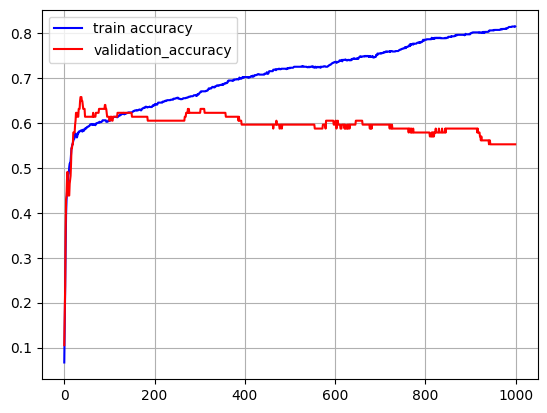

In [100]:
plt.plot(train_acc, label = 'train accuracy', c = 'b')
plt.plot(val_acc, label = f'validation_accuracy', c = 'red')
plt.grid(True)
plt.legend()

Text(0, 0.5, 'loss')

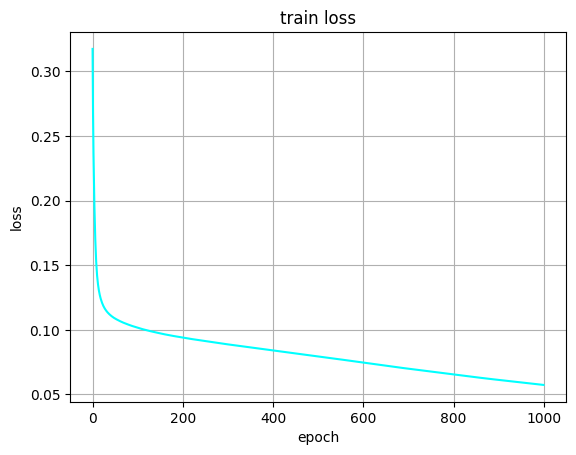

In [103]:
plt.grid(True)
plt.plot(train_loss, c='cyan')
plt.title('train loss')
plt.xlabel('epoch')
plt.ylabel('loss')

In [109]:
# test accuracy
print('test accuracy: ', (network.predict(x_te) == test_label).mean())

test accuracy:  0.5826086956521739


In [49]:
y_hat = network.predict(x_te)

In [50]:
from sklearn.metrics import classification_report

display(classification_report(y_true=y_test, y_pred=y_hat))

C:\Users\kara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: U

'              precision    recall  f1-score   support\n\n         3.0       0.00      0.00      0.00         1\n         4.0       0.00      0.00      0.00         1\n         5.0       0.68      0.61      0.65        49\n         6.0       0.52      0.62      0.56        47\n         7.0       0.50      0.43      0.46        14\n         8.0       0.00      0.00      0.00         3\n\n    accuracy                           0.57       115\n   macro avg       0.28      0.28      0.28       115\nweighted avg       0.56      0.57      0.56       115\n'

In [116]:
# train with deifferent learning rates
def train_model(lr, colors):

    fig, ax = plt.subplots(15, 2)

    for i in range(15):

        network = MLP(lr[i])

        network.add_layer(Layer(11, 64, 'relu', 'He', 'zeros'))
        # network.add_layer(Layer(256, 256, 'relu', 'xavier', 'zeros'))
        network.add_layer(Layer(64, 16, 'relu', 'He', 'zeros'))
        network.add_layer(Layer(16, 9, 'None', 'He', 'zeros'))

        train_acc = []
        train_loss = []
        val_acc = []
        epochs = 100
        for epoch in range(epochs):

            loss = network.fit(x_tr,y_tr, 8)

            train_loss.append(loss)
            train_acc.append((network.predict(x_tr) == train_label).mean())
            val_acc.append((network.predict(x_val) == val_label).mean())
        
            
        ax[i][0].plot(train_acc, label = 'train accuracy', c = 'b')
        ax[i][0].plot(val_acc, label = f'validation_accuracy for lr = {lr[i]}', c = colors[i])
        ax[i][0].legend()

        ax[i][1].plot(train_loss, label = f'train loss for lr = {lr[i]}', c = colors[i])
        ax[i][1].legend()
        fig.set_size_inches((8, 45))
        # fig.legend()

### 4-2- Testing different learning rates

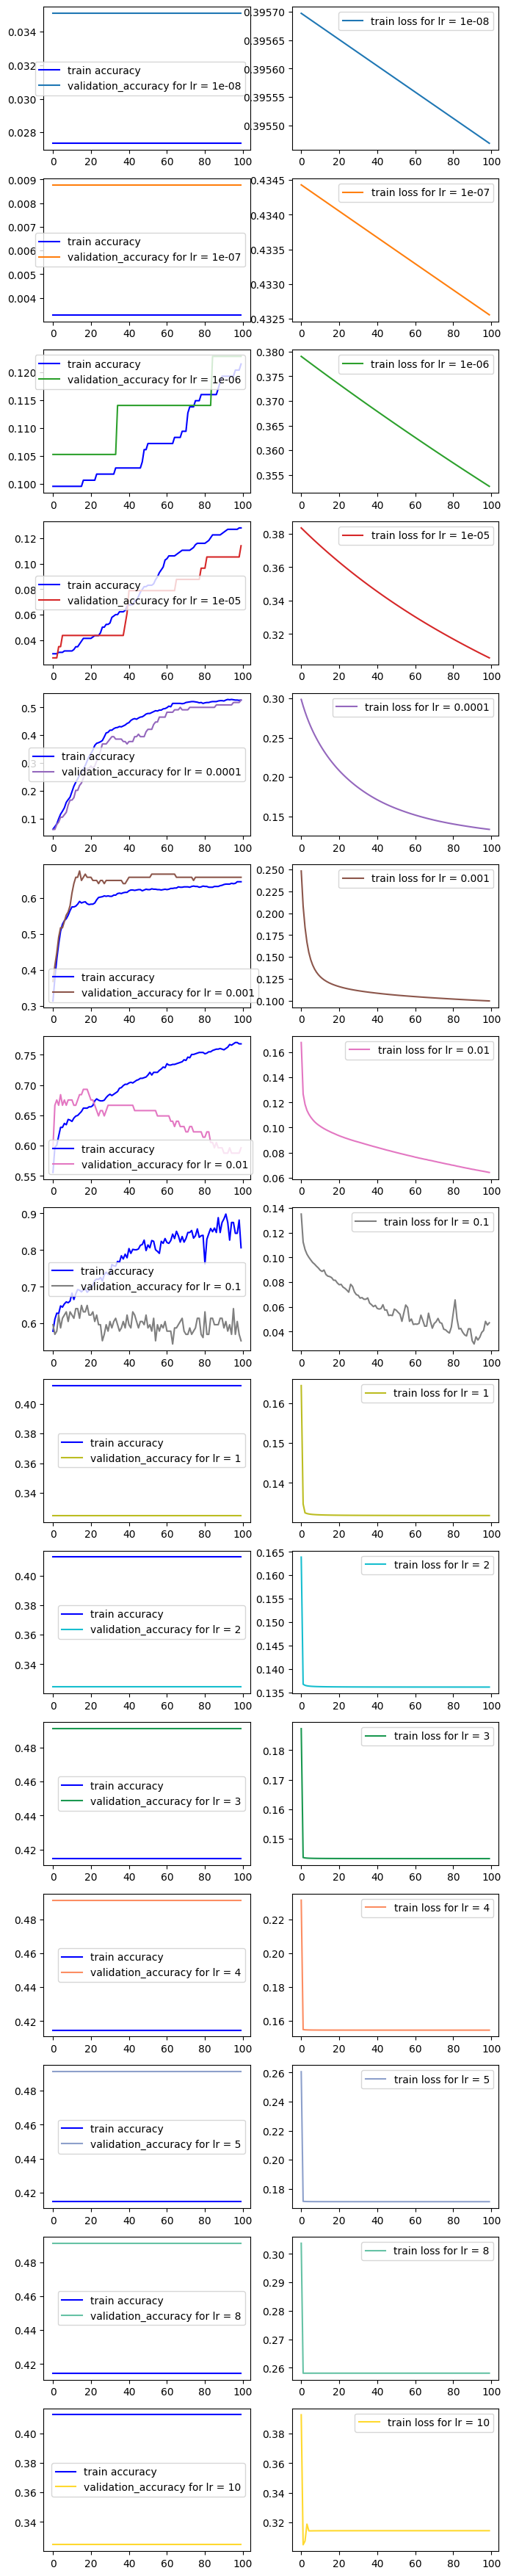

In [117]:
lr = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 8, 10]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#1a9850', '#fc8d62', '#8da0cb', '#66c2a5', '#ffd92f']

train_model(lr, colors)

# 5- Imbalance learning technique

In [53]:
df = pd.read_csv("data\WineQT.csv")

In [54]:
df.drop(['Id'], axis = 1, inplace=True)

In [61]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6


In [55]:
df.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.250728,0.673157,0.171831,0.107889,-0.164831,-0.110628,0.681501,-0.685163,0.174592,-0.075055,0.121970
volatile acidity,-0.250728,1.000000,-0.544187,-0.005751,0.056336,-0.001962,0.077748,0.016512,0.221492,-0.276079,-0.203909,-0.407394
citric acid,0.673157,-0.544187,1.000000,0.175815,0.245312,-0.057589,0.036871,0.375243,-0.546339,0.331232,0.106250,0.240821
residual sugar,0.171831,-0.005751,0.175815,1.000000,0.070863,0.165339,0.190790,0.380147,-0.116959,0.017475,0.058421,0.022002
chlorides,0.107889,0.056336,0.245312,0.070863,1.000000,0.015280,0.048163,0.208901,-0.277759,0.374784,-0.229917,-0.124085
free sulfur dioxide,-0.164831,-0.001962,-0.057589,0.165339,0.015280,1.000000,0.661093,-0.054150,0.072804,0.034445,-0.047095,-0.063260
total sulfur dioxide,-0.110628,0.077748,0.036871,0.190790,0.048163,0.661093,1.000000,0.050175,-0.059126,0.026894,-0.188165,-0.183339
density,0.681501,0.016512,0.375243,0.380147,0.208901,-0.054150,0.050175,1.000000,-0.352775,0.143139,-0.494727,-0.175208
pH,-0.685163,0.221492,-0.546339,-0.116959,-0.277759,0.072804,-0.059126,-0.352775,1.000000,-0.185499,0.225322,-0.052453
sulphates,0.174592,-0.276079,0.331232,0.017475,0.374784,0.034445,0.026894,0.143139,-0.185499,1.000000,0.094421,0.257710


<Axes: >

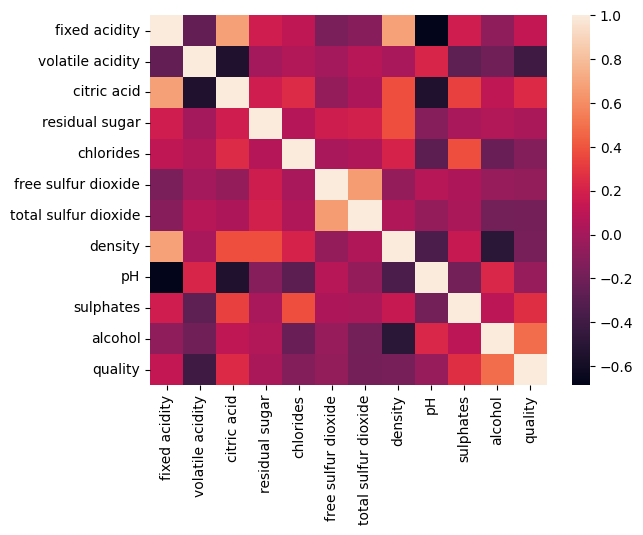

In [56]:
sns.heatmap(df.corr())

C:\Users\kara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


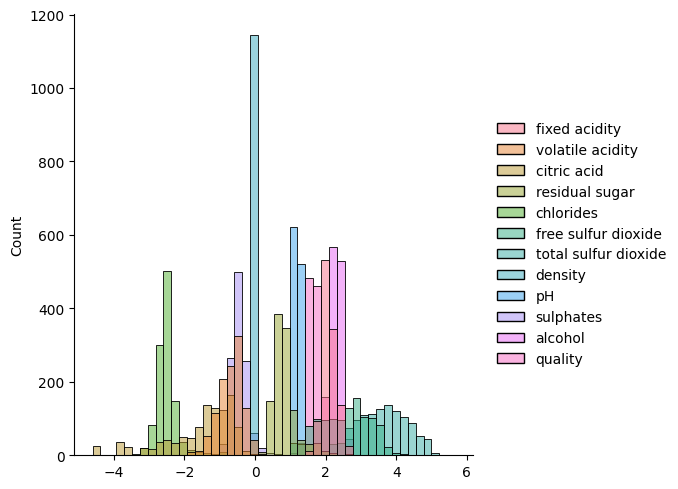

In [57]:
sns.displot(np.log(df))

array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>],
       [<Axes: title={'center': 'residual sugar'}>,
        <Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>],
       [<Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'pH'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>]], dtype=object)

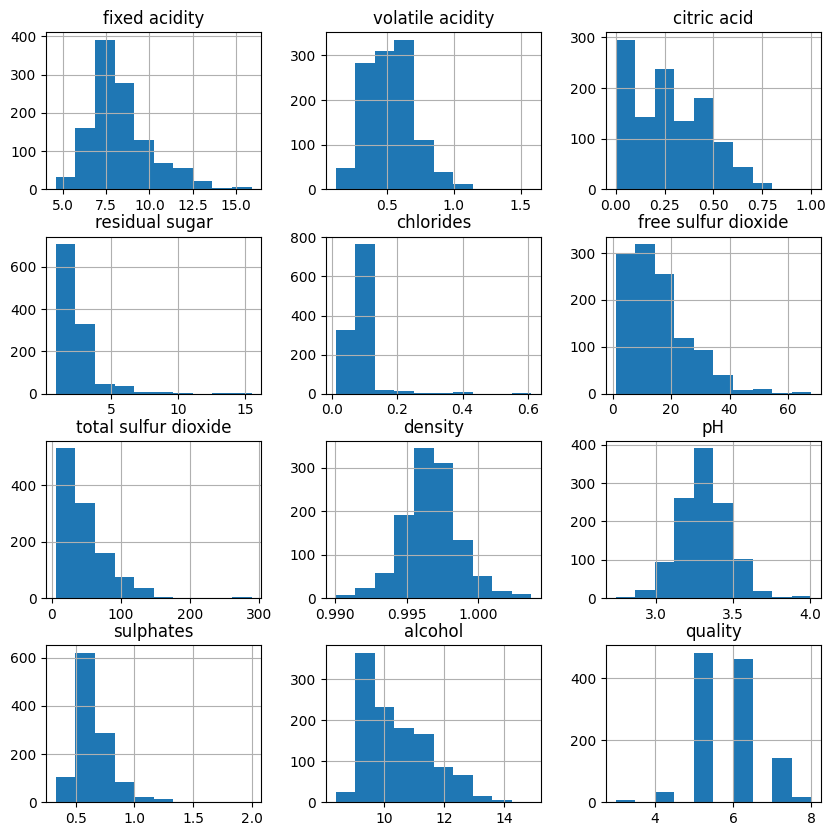

In [58]:
df.hist(figsize=(10, 10))

<Axes: xlabel='quality', ylabel='count'>

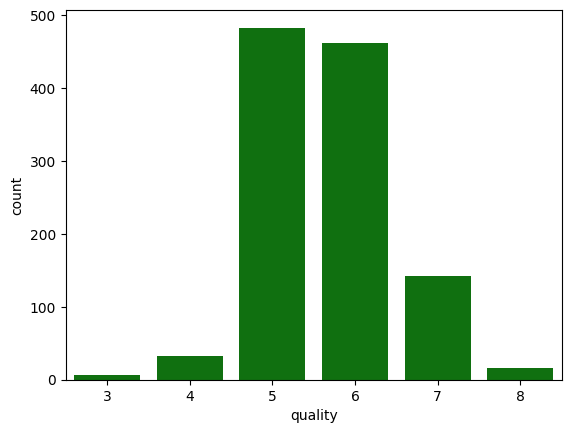

In [139]:
# number of values of different qualities
sns.barplot(data = df['quality'].value_counts(), color='green')

In [149]:
from imblearn.over_sampling import SMOTE

X = df.drop(['quality'], axis=1)
y = df['quality']

x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)


# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
x_train_resampled, x_test, y_train_resampled, y_test = np.array(x_train_resampled), np.array(x_test) , np.array(y_train_resampled), np.array(y_test)
x_val, y_val = np.array(x_val), np.array(y_val)

x_tr = standardize_data(x_train_resampled)
x_te = standardize_data(x_test)
x_val = standardize_data(x_val)

y_tr = onehot_encoding(y_train_resampled)
y_te = onehot_encoding(y_test)
y_val = onehot_encoding(y_val)

In [150]:
network = MLP(0.001)
network.add_layer(Layer(11, 64, 'relu', 'He', 'zeros'))
network.add_layer(Layer(64, 16, 'relu', 'He', 'zeros'))
network.add_layer(Layer(16, 9, 'None', 'He', 'zeros'))

In [151]:
train_label = y_tr.argmax(axis= 1)
test_label = y_te.argmax(axis= 1)
val_label = y_val.argmax(axis = 1)

In [152]:
# training loop
train_acc = []
train_loss = []
val_acc = []
epochs = 1000
for epoch in tqdm(range(epochs),desc="Training", unit="epoch"):
    loss = network.fit(x_tr,y_tr, 8)
    train_loss.append(loss)
    train_acc.append((network.predict(x_tr) == train_label).mean())
    val_acc.append((network.predict(x_val) == val_label).mean())

Training: 100%|██████████| 1000/1000 [00:30<00:00, 33.01epoch/s]


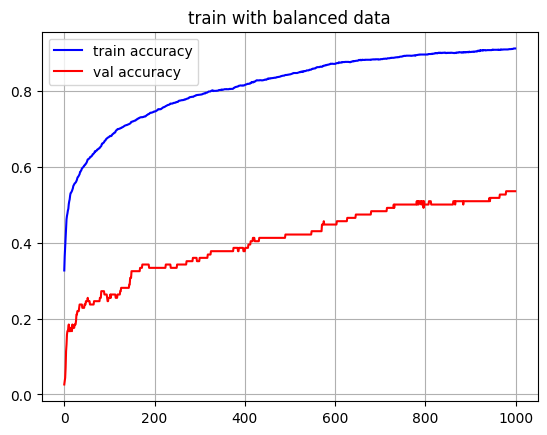

In [154]:
plt.plot(train_acc, label = 'train accuracy', c = 'b')
plt.plot(val_acc, label = 'val accuracy', c = 'r')
plt.title('train with balanced data')
plt.grid(True)
plt.legend()

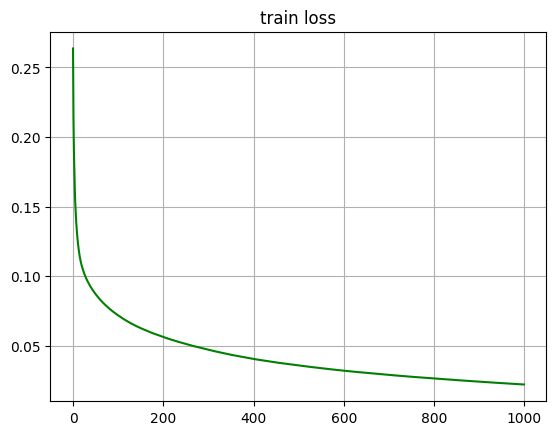

In [160]:
plt.plot(train_loss, c= 'green')
plt.title('train loss')
plt.grid(True)

In [158]:
(network.predict(x_te) == test_label).mean()

0.46956521739130436

In [157]:
y_hat = network.predict(x_te)
classification_report(y_true=y_test, y_pred=y_hat)

C:\Users\kara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWa

'              precision    recall  f1-score   support\n\n           3       0.00      0.00      0.00         0\n           4       0.07      0.33      0.12         3\n           5       0.69      0.44      0.54        50\n           6       0.55      0.48      0.51        44\n           7       0.45      0.62      0.53        16\n           8       0.00      0.00      0.00         2\n\n    accuracy                           0.47       115\n   macro avg       0.29      0.31      0.28       115\nweighted avg       0.58      0.47      0.51       115\n'

# 6- Testing data with Pytorch package

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = np.array(x_train), np.array(x_test) , np.array(y_train), np.array(y_test)
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.LongTensor(y_train)  # Use LongTensor for integer labels
X_test_tensor = torch.Tensor(x_test)
y_test_tensor = torch.LongTensor(y_test)    # Use LongTensor for integer labels

# Define the neural network model
class WineQualityPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(WineQualityPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [79]:
input_size = x_train.shape[1]
hidden_size = 512
output_size = 9  
model = WineQualityPredictor(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

num_epochs = 3000
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy}")


Epoch [1/3000], Loss: 1.0998917818069458
Epoch [2/3000], Loss: 0.7408180832862854
Epoch [3/3000], Loss: 0.9471170902252197
Epoch [4/3000], Loss: 1.9317882061004639
Epoch [5/3000], Loss: 2.377612829208374
Epoch [6/3000], Loss: 1.833648920059204
Epoch [7/3000], Loss: 0.8318042159080505
Epoch [8/3000], Loss: 2.683929443359375
Epoch [9/3000], Loss: 0.389670193195343
Epoch [10/3000], Loss: 0.8137921690940857
Epoch [11/3000], Loss: 1.2980010509490967
Epoch [12/3000], Loss: 3.1687209606170654
Epoch [13/3000], Loss: 0.9195034503936768
Epoch [14/3000], Loss: 1.0596472024917603
Epoch [15/3000], Loss: 4.060626029968262
Epoch [16/3000], Loss: 1.2194244861602783
Epoch [17/3000], Loss: 0.4011997580528259
Epoch [18/3000], Loss: 0.814016580581665
Epoch [19/3000], Loss: 1.1639206409454346
Epoch [20/3000], Loss: 1.2617201805114746
Epoch [21/3000], Loss: 1.0155037641525269
Epoch [22/3000], Loss: 0.2088017612695694
Epoch [23/3000], Loss: 1.3418117761611938
Epoch [24/3000], Loss: 0.6464122533798218
Epoch [